## Multi-Class Distributions
We define a set of multi-class distributions that are wrappers around sklearn classifiers and/or distributions  
They can be used for Bayesian Classification and for Likelihood Computations in HMMs / Decision Trees
Some are very simple wrappers around an existing sklearn Classifier.   
The API is largely derived from sklearn with the same data structures and methods.

In the NB variants (Dist_Gauss, Dist_Disc) everything is organized per feature
in the GMM case (Dist_GMM) organization is rather per class


#### Data and Classes

    X: ndarray (n_samples, n_features)   SHOULD BE 2D
    y: ndarray (n_samples, )
        y is either integers (unnamed classes) or strings (named classes) classes_ holds the class names, it is either inferred from training data or can be set
    
#### Methods (as in sklearn)

    .fit(X,y)               train from examples   
    .predict_proba(X)       get probabilities of feature vectors   
    .predict_log_proba(X)   get log probabilities of feature vectors   
    .predict(X)             get predicted classes from X   

#### Methods (added in pyspch)
    .print_model()          prints the key attributes of the model for each feature or per class
    .plot_model()           plots the distribution for each feature or per class
    
#### Attributes
    classes_      class names   
    class_count_  class count from training data   
    class_prior_  class prior from training   

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.light_palette("caramel",50,input="xkcd")
import pandas as pd
from pyspch.io.sequence_data import make_seq1, make_seq1d
from IPython.display import display, HTML, clear_output

In [2]:
from scipy.stats import norm
class Dist_Gauss(GaussianNB):
    def validate_(self):
        """ checks that both sigma_ / var_ are in the model """
        if (not hasattr(self,'var_')) and (hasattr(self,'sigma_')) :
            self.var_ = np.square(self.sigma_)        
    def print_model(self):
        self.validate_()
        print('Means')
        print(self.theta_)
        print('Variance')
        print(self.var_)   
        
    def plot_model(self):
        nclass, n_features = self.theta_.shape
        f,ax = plt.subplots(1,n_features,figsize=(14,5))
        for j in range(n_features):
            for i in range(nclass):
                mu = self.theta_[i,j]
                sigma = np.sqrt(self.var_[i,j])
                xx = np.linspace(mu-2*sigma,mu+2*sigma,100)
                ax[j].plot(xx, norm.pdf(xx, mu, sigma))
            ax[j].legend(self.classes_)
            ax[j].set_title("Feature (%d)" %j)   


In [3]:
class Dist_Discr(CategoricalNB):
    """
    feature_log_prob_ : list of arrays of shape (n_features,)
        Holds arrays of shape (n_classes, n_categories of respective feature) for each feature.
    """
    def print_model(self,per_class=False):
        if per_class:
            n_classes = len(self.classes_)
            for i in range(n_classes): self.print_class(i)
        else:
            n_features = len(self.feature_log_prob_)
            for i in range(n_features): self.print_feature(i)
            
    def print_feature(self,feat_id):            
        print(" ++ Feature(%d) ++ "%feat_id)
        proba = np.exp(self.feature_log_prob_[feat_id])
        print(proba)

    def get_class_log_proba(self,class_id):
        """ get probs per class as n_feature lists of prob arrasy """
        class_data = []
        n_features = len(self.feature_log_prob_)
        for j in range(n_features):
            proba = self.feature_log_prob_[j][class_id,:]
            class_data.append(proba)
        return(class_data)
    
    def get_class_proba(self,class_id):
        """ get probs per class as n_feature lists of prob arrasy """
        class_data = []
        n_features = len(self.feature_log_prob_)
        for j in range(n_features):
            proba = np.exp(self.feature_log_prob_[j][class_id,:])
            class_data.append(proba)
        return(class_data)
    
    def print_class(self,class_id):
        print(" ++ Class(%d) ++ "%class_id)
        n_features = len(self.feature_log_prob_)
        for j in range(n_features):
            proba = np.exp(self.feature_log_prob_[j][class_id,:])
            print(proba)

    def plot_model(self):
        barwidth = .2
        n_features = len(self.feature_log_prob_)
        f,ax = plt.subplots(1,n_features,figsize=(14,5))
        for j in range(n_features):
            proba = np.exp(self.feature_log_prob_[j])
            nclass,nbins = proba.shape
            xs = np.arange(nbins)
            for i in range(nclass):
                ax[j].bar(xs+i*barwidth,proba[i,:],width=barwidth)
                ax[j].set_xticks([xx for xx in range(nbins) ])
            ax[j].legend(np.arange(nclass))


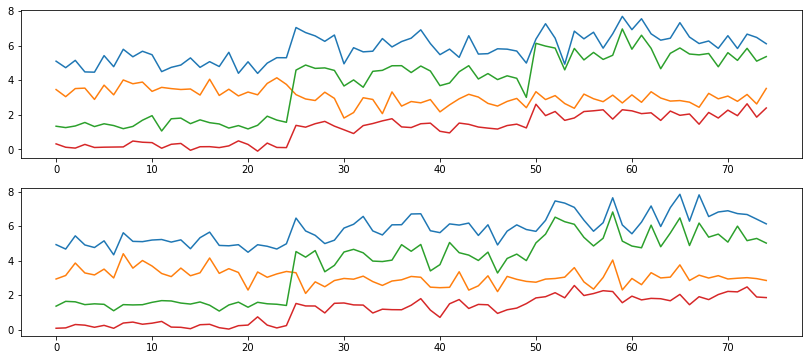

In [4]:
(X1,y1), (X2,y2) = make_seq1()
f,ax=plt.subplots(2,figsize=(14,6))
ax[0].plot(X1)
ax[1].plot(X2);

### Gaussian Distributions
#### 1. Training
Train on Set 1 and Test on Set 2

In [5]:
# create some data
#
# train a Gaussian model from the training data
gModel1 = Dist_Gauss()
gModel1.fit(X1, y1)
gModel1.print_model()

Means
[[5.02288795 3.50419003 1.48718346 0.21015772]
 [5.99927158 2.73958951 4.32244769 1.35543352]
 [6.51669384 2.93893153 5.58150611 2.07777653]]
Variance
[[0.16508004 0.11026139 0.05307663 0.02307028]
 [0.31099804 0.14610678 0.22299327 0.04144266]
 [0.33806218 0.08008419 0.28329631 0.0784345 ]]


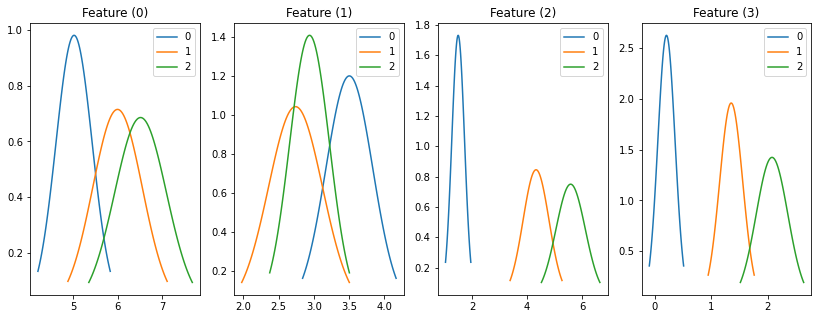

In [6]:
gModel1.plot_model()

In [7]:
gModel1.__dict__

{'priors': None,
 'var_smoothing': 1e-09,
 'classes_': array([0, 1, 2]),
 'n_features_in_': 4,
 'epsilon_': 3.118391984073748e-09,
 'theta_': array([[5.02288795, 3.50419003, 1.48718346, 0.21015772],
        [5.99927158, 2.73958951, 4.32244769, 1.35543352],
        [6.51669384, 2.93893153, 5.58150611, 2.07777653]]),
 'var_': array([[0.16508004, 0.11026139, 0.05307663, 0.02307028],
        [0.31099804, 0.14610678, 0.22299327, 0.04144266],
        [0.33806218, 0.08008419, 0.28329631, 0.0784345 ]]),
 'class_count_': array([25., 25., 25.]),
 'class_prior_': array([0.33333333, 0.33333333, 0.33333333])}

### Sample Likelihoods per Class

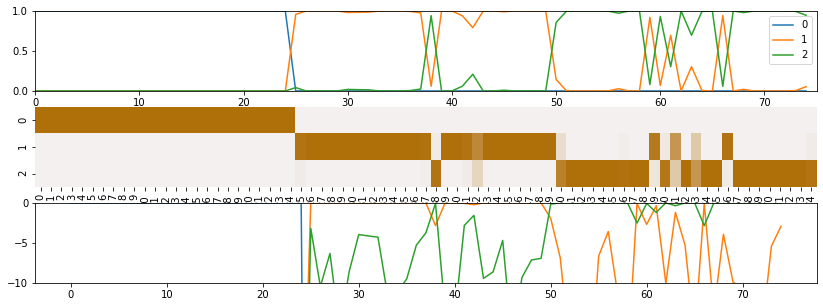

In [8]:
probs=gModel1.predict_proba(X2)
log_probs=gModel1.predict_log_proba(X2)
f,ax=plt.subplots(3,figsize=(14,5))
ax[0].plot(probs)
ax[0].set_xlim([0.,probs.shape[0]])
ax[0].set_ylim([0,1.])
ax[0].legend(gModel1.classes_)
sns.heatmap(probs.T,ax=ax[1],vmax=1,vmin=0.0,yticklabels=gModel1.classes_,
            cmap=cmap,cbar=False, linewidth=0, linecolor='k')
ax[2].plot(log_probs)
ax[2].set_ylim([-10,0.]);

In [9]:
# let's make a bit harder by adding some noise to the test data
X3 = X2 + np.random.normal(loc=0.,scale=1,size=X2.shape)

### Classification

In [10]:
y_pred = gModel1.predict(X2)
print("Test Set: Number of mislabeled points out of a total %d points : %d" % (X2.shape[0], (y2 != y_pred).sum()))
y_pred = gModel1.predict(X3)
print("Noisy Set: Number of mislabeled points out of a total %d points : %d" % (X3.shape[0], (y2 != y_pred).sum()))

Test Set: Number of mislabeled points out of a total 75 points : 4
Noisy Set: Number of mislabeled points out of a total 75 points : 22


## Discrete Densities aka Categorical NB

In [11]:
(X1d,y1), (X2d,y2) = make_seq1d()
_, (X3d,y3) = make_seq1d(noise=1)
#

In [12]:
X1d = X1d[:,0:2]
X2d = X2d[:,0:2]
X3d = X3d[:,0:2]

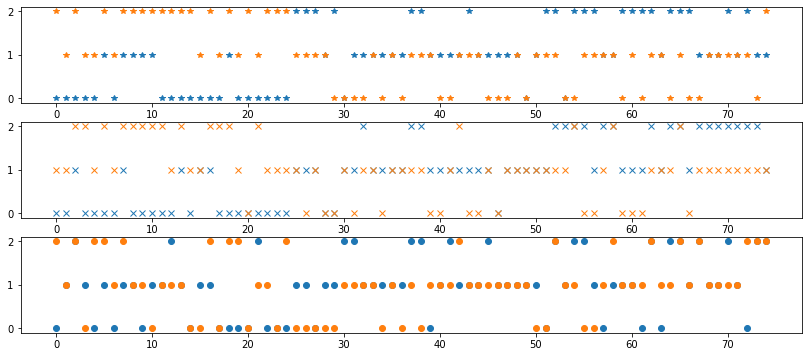

In [13]:
f,ax=plt.subplots(3,figsize=(14,6))
ax[0].plot(X1d,'*')
ax[1].plot(X2d,'x');
ax[2].plot(X3d,'o');

In [14]:
dd1 = Dist_Discr()
dd1.alpha = 1
dd1.fit(X=X1d,y=y1)

Dist_Discr(alpha=1)

In [15]:
dd1.__dict__

{'alpha': 1,
 'fit_prior': True,
 'class_prior': None,
 'min_categories': None,
 'n_features_in_': 2,
 'classes_': array([0, 1, 2]),
 'class_count_': array([25., 25., 25.]),
 'category_count_': [array([[19.,  6.,  0.],
         [ 2., 16.,  7.],
         [ 1., 10., 14.]]),
  array([[ 0.,  8., 17.],
         [12., 13.,  0.],
         [ 8., 16.,  1.]])],
 'n_categories_': array([3, 3]),
 'feature_log_prob_': [array([[-0.33647224, -1.38629436, -3.33220451],
         [-2.23359222, -0.49899117, -1.25276297],
         [-2.63905733, -0.93430924, -0.62415431]]),
  array([[-3.33220451, -1.13497993, -0.44183275],
         [-0.76725515, -0.69314718, -3.33220451],
         [-1.13497993, -0.49899117, -2.63905733]])],
 'class_log_prior_': array([-1.09861229, -1.09861229, -1.09861229])}

 ++ Feature(0) ++ 
[[0.71428571 0.25       0.03571429]
 [0.10714286 0.60714286 0.28571429]
 [0.07142857 0.39285714 0.53571429]]
 ++ Feature(1) ++ 
[[0.03571429 0.32142857 0.64285714]
 [0.46428571 0.5        0.03571429]
 [0.32142857 0.60714286 0.07142857]]


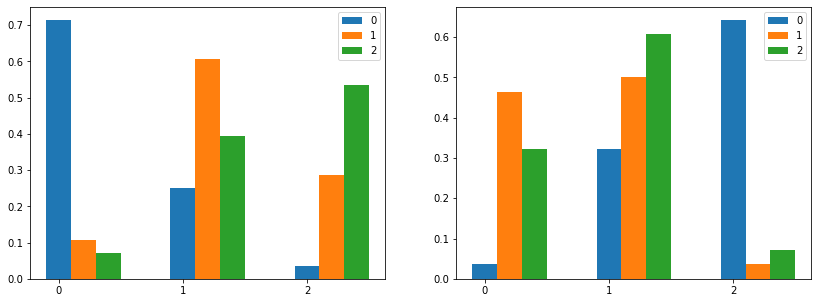

In [16]:
dd1.plot_model()
dd1.print_model()

In [17]:
dd1.get_class_proba(0)

[array([0.71428571, 0.25      , 0.03571429]),
 array([0.03571429, 0.32142857, 0.64285714])]

In [18]:
dd1.print_model(per_class=True)

 ++ Class(0) ++ 
[0.71428571 0.25       0.03571429]
[0.03571429 0.32142857 0.64285714]
 ++ Class(1) ++ 
[0.10714286 0.60714286 0.28571429]
[0.46428571 0.5        0.03571429]
 ++ Class(2) ++ 
[0.07142857 0.39285714 0.53571429]
[0.32142857 0.60714286 0.07142857]


In [19]:
y_pred = dd1.predict(X2d)
print("Test Set: Number of mislabeled points out of a total %d points : %d" % (X2d.shape[0], (y2 != y_pred).sum()))
y_pred = dd1.predict(X3d)
print("Noisy Set: Number of mislabeled points out of a total %d points : %d" % (X3d.shape[0], (y2 != y_pred).sum()))

Test Set: Number of mislabeled points out of a total 75 points : 15
Noisy Set: Number of mislabeled points out of a total 75 points : 37


In [20]:
dd1.score(X3d,y3)

0.5066666666666667

<AxesSubplot:>

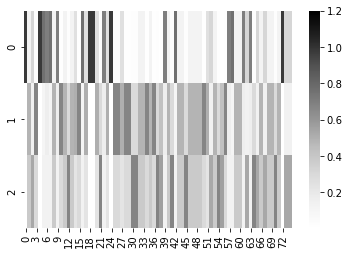

In [21]:
sns.heatmap(dd1.predict_proba(X3d).T,cmap='Greys',vmax=1.2)

### HMM Recognition

In [22]:
from pyspch import libhmm 
from pyspch import utils as spchu
#from pyspch import Dist

dd1.print_model(per_class=True)


 ++ Class(0) ++ 
[0.71428571 0.25       0.03571429]
[0.03571429 0.32142857 0.64285714]
 ++ Class(1) ++ 
[0.10714286 0.60714286 0.28571429]
[0.46428571 0.5        0.03571429]
 ++ Class(2) ++ 
[0.07142857 0.39285714 0.53571429]
[0.32142857 0.60714286 0.07142857]


In [23]:
imat = np.array([1.0, 0.0, 0.])
tmat = np.array([[.8,.2,0.],[0.,.8,.2],[0.,0.,1.]])

hmm1 = libhmm.HMM(n_states=3,prob_style="lin",obs_model=dd1,
                  transmat=tmat,initmat=imat)
hmm1.print_model()

HMM STATE MODEL



,S0,S1,S2
Pinit(S.),1.0,0.0,0.0


,S0,S1,S2
P(S0|S.),0.8,0.0,0.0
P(S1|S.),0.2,0.8,0.0
P(S2|S.),0.0,0.2,1.0


OBSERVATION MODEL

 ++ Feature(0) ++ 
[[0.71428571 0.25       0.03571429]
 [0.10714286 0.60714286 0.28571429]
 [0.07142857 0.39285714 0.53571429]]
 ++ Feature(1) ++ 
[[0.03571429 0.32142857 0.64285714]
 [0.46428571 0.5        0.03571429]
 [0.32142857 0.60714286 0.07142857]]


In [24]:
X=X2d
tr = libhmm.Trellis(hmm1)
tr.viterbi_pass(X2d)
tr.backptrs.T, tr.backtrace()

(array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 2, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  2,  2,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,

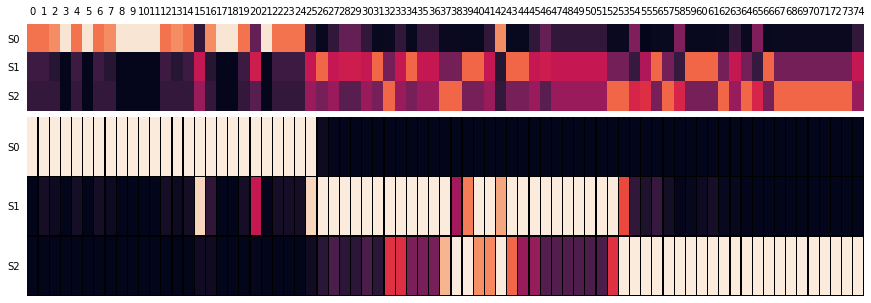

In [25]:
tr.plot_trellis(plot_norm=True,plot_obs_probs=True,plot_values=False,vmin=0.,vmax=1,figsize=(15,5))

In [26]:
hmm1.obs_model.__dict__

{'alpha': 1,
 'fit_prior': True,
 'class_prior': None,
 'min_categories': None,
 'n_features_in_': 2,
 'classes_': array([0, 1, 2]),
 'class_count_': array([25., 25., 25.]),
 'category_count_': [array([[19.,  6.,  0.],
         [ 2., 16.,  7.],
         [ 1., 10., 14.]]),
  array([[ 0.,  8., 17.],
         [12., 13.,  0.],
         [ 8., 16.,  1.]])],
 'n_categories_': array([3, 3]),
 'feature_log_prob_': [array([[-0.33647224, -1.38629436, -3.33220451],
         [-2.23359222, -0.49899117, -1.25276297],
         [-2.63905733, -0.93430924, -0.62415431]]),
  array([[-3.33220451, -1.13497993, -0.44183275],
         [-0.76725515, -0.69314718, -3.33220451],
         [-1.13497993, -0.49899117, -2.63905733]])],
 'class_log_prior_': array([-1.09861229, -1.09861229, -1.09861229])}

In [29]:
# filling the trellis in a time synchronous way
X=X2d
tr_ = libhmm.Trellis(hmm1)
#N = obs_probs.shape[0]
for i in range(10):
    clear_output(wait=True)
    tr_.viterbi_step(X[i,:])
    tr_.print_trellis(what=['obs_probs','probs'],Titles=True)
    tr_.plot_trellis(xticks=X[0:i],plot_obs_probs=True,plot_backptrs=True,plot_alignment=True,
                plot_norm=True,vmin=0.,vmax=2)
    #time.sleep(2)

Observation Probabilities



,0,1,2,3,4,5,6,7,8,9
S0,0.703125,0.703125,0.763636,0.980926,0.703125,0.980926,0.703125,0.763636,0.980926,0.980926
S1,0.164062,0.164062,0.103030,0.008174,0.164062,0.008174,0.164062,0.103030,0.008174,0.008174
S2,0.132813,0.132813,0.133333,0.010899,0.132813,0.010899,0.132813,0.133333,0.010899,0.010899


Trellis Probabilities (Viterbi)



,0,1,2,3,4,5,6,7,8,9
S0,0.703125,0.395508,0.241619,0.189609,0.106655,0.083696,0.047079,0.028761,0.022570,1.771165e-02
S1,0.000000,0.023071,0.008150,0.000395,0.006222,0.000174,0.002746,0.000970,0.000047,3.689927e-05
S2,0.000000,0.000000,0.000615,0.000018,0.000010,0.000014,0.000005,0.000073,0.000002,1.024980e-07


C:\Users\compi\Anaconda3\envs\py37\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
